# 드라이브 마운트

In [ ]:
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 다들 MyDrive에 공유 폴더 바로가기 추가해놓으세요.
!ls "/content/drive/MyDrive/2025-2. 홍콩대 학술교류"

 BERT.ipynb	     sources.gsheet		    라벨링			 발표준비
 LLAMA시어.ipynb    'UMAP 더보기.gdoc'		   '말뭉치 자료'		 의미론-애꿎다
 LLAMA실험.ipynb     Untitled0.ipynb		   '말뭉치 확인용(차다).ipynb'	'필터링 결과'
 LLAMA의미론.ipynb   v1_classified_sentences.xlsx  '말뭉치 확인용(타다).ipynb'
 NanumGothic.ttf     기타자료			   '말뭉치 확인용(통합).ipynb'


# 4bit 양자화 버전 <= T4로도 충분히 돌아감

필수 라이브러리 설치

In [ ]:
!pip install -U -q transformers accelerate bitsandbytes umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.1/342.1 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.

In [ ]:
# 버전 확인
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
!nvidia-smi

CUDA available: True
CUDA version: 12.4
Wed Feb 19 06:18:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------

모델 구동

In [ ]:
from huggingface_hub import notebook_login

# hf 토큰이 필요함. llama-3.1-8b 다운받으려면 어쩔 수 없음.
notebook_login()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕 폰트 파일 경로 설정 (드라이브 마운트 후)
font_path = '/content/drive/MyDrive/2025-2. 홍콩대 학술교류/NanumGothic.ttf'

# 폰트 추가
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_prop.get_name()

def get_gpu_memory():
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024 ** 2  # MB 단위 변환
    return 0  # GPU가 없을 경우 0 반환

# 4bit 양자화 설정
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

# LLaMA 모델 로드
# 한국어 잘하는 다른 8b 모델도 다운 받아볼까? bllossom 같은 거. 리더보드 1등 가져오고 그러면 되겠다잉.
"""왜 LLM을 쓰는가? LLM은 유사도 기반 정적 벡터와는 달리 문맥에 따라 토큰의 정보가 그때그때 달라지는 동적벡터이기 때문에 그렇다."""
#model_name = "beomi/open-llama-2-ko-7b" # 6분 걸림
model_name = "meta-llama/Llama-3.1-8B" # 7분 걸림
#model_name = "sh2orc/Llama-3.1-Korean-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## 토큰 확인용

In [ ]:
# 한국어 토큰

import re

# 토큰 딕셔너리 가져오기
vocab = tokenizer.get_vocab()
id_to_token = {v: k for k, v in vocab.items()}  # ID -> 토큰 매핑

# 한글 유니코드 범위
korean_regex = re.compile(r"[\uAC00-\uD7A3\u1100-\u11FF\u3130-\u318F]+")

# 토큰을 ID로 변환 후 다시 디코딩하여 한글 토큰 확인
korean_tokens = []
for token_id in range(len(id_to_token)):
    token = id_to_token[token_id]  # 원본 토큰
    decoded_token = tokenizer.decode([token_id])  # 디코딩된 토큰

    # 깨진 유니코드가 있으면 복원 시도
    if not korean_regex.search(decoded_token):  # 한글이 없으면
        try:
            fixed_token = decoded_token.encode('utf-8').decode('utf-8')  # 유니코드 복원
        except UnicodeDecodeError:
            fixed_token = decoded_token  # 복원 실패 시 그대로 유지
    else:
        fixed_token = decoded_token  # 원래 한글이면 그대로 사용

    # 한글이 포함된 경우만 저장
    if korean_regex.search(fixed_token):
        korean_tokens.append(fixed_token)

# 정렬해서 출력
korean_tokens = sorted(set(korean_tokens))
print(korean_tokens[:50])  # 상위 50개 출력

print(len(korean_tokens))

[' ㅇ', ' ㅇㅇ', ' ㅋㅋ', ' ㅡ', ' 가', ' 가격', ' 가까', ' 가능', ' 가능한', ' 가입', ' 가장', ' 가정', ' 가져', ' 가족', ' 가지', ' 가지고', ' 가진', ' 각', ' 각각', ' 간', ' 갈', ' 감', ' 감독', ' 감사', ' 갑', ' 값', ' 값을', ' 강', ' 강남', ' 갖', ' 같', ' 같다', ' 같습니다', ' 같은', ' 같이', ' 개', ' 개발', ' 개인', ' 개최', ' 객', ' 객체', ' 갤', ' 갤로그', ' 갤로그로', ' 거', ' 거래', ' 거야', ' 거의', ' 건', ' 건강']
2288


In [ ]:
"""특수 토큰(문장 시작 끝 등) 확인용 """

"""라마 3.1의 특수 토큰들
['<|begin_of_text|>', '<|end_of_text|>']
[128000, 128001]
"""

# 기본적인 특수 토큰 확인 방법
special_tokens = tokenizer.all_special_tokens
special_token_ids = tokenizer.all_special_ids

# print
print(special_tokens)
print(special_token_ids)

['<|begin_of_text|>', '<|end_of_text|>']
[128000, 128001]


# 기존 코드

## 상수 지정

In [ ]:
def get_token_id(token_list):
    """입력된 문자열 리스트에 대해 토큰 ID를 반환"""
    token_ids = [tokenizer.encode(token, add_special_tokens=False) for token in token_list]
    return dict(zip(token_list, token_ids))

# 테스트할 토큰 리스트
# 여기서 지정해서 검색
symbols_to_find = ["[", "]"] # 얘네가 tokenizer 사전에 존재하면 다 가져오기?
tokens_to_find = ["차","찹", "찼", "찬", "참", "찰"]
is_it_really_exist = ["[차]", "[차", "차]", "[찹", "찹]", "[찬", "찬]"]

# 토큰 ID 조회
symbol_ids_dict = get_token_id(symbols_to_find)
print("특수문자 :", symbol_ids_dict)
token_ids_dict = get_token_id(tokens_to_find)
print("토큰 :", token_ids_dict)
is_it_really_exist_dict = get_token_id(is_it_really_exist)
print("찾아보기 :", is_it_really_exist_dict)

In [ ]:
# SELECTED_TOKEN_IDS를 set으로 저장 (단일 토큰은 정수, 다중 토큰은 튜플로 변환)

SYMBOL_TOKEN_IDS = {
    tuple(ids) if len(ids) > 1 else ids[0]  # 다중 토큰은 튜플, 단일 토큰은 정수
    for ids in symbol_ids_dict.values()
}

SELECTED_TOKEN_IDS = {
    tuple(ids) if len(ids) > 1 else ids[0]  # 다중 토큰은 튜플, 단일 토큰은 정수
    for ids in token_ids_dict.values()
}

# 결과 출력
print("특수문자 토큰 id :", SYMBOL_TOKEN_IDS)
print("토큰 id", SELECTED_TOKEN_IDS)

## 기초 코드

In [ ]:
import numpy as np
import matplotlib.cm as cm
from tqdm import tqdm
import pandas as pd
import gspread
from google.colab import auth
from google.auth import default

# 구글 인증
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# 스프레드시트 데이터로 변환
sh = gc.open("sources")
token_sheet = sh.worksheet("토큰들")
token_data = token_sheet.get_all_values()
token_df = pd.DataFrame(token_data[1:], columns=token_data[0])

# 토큰 ID를 키, 텍스트를 값으로 하는 매핑 딕셔너리 생성
token_id_to_text = {int(row["토큰ID"]): row["텍스트"] for _, row in token_df.iterrows()}

def clean_token(token_id):
    """토큰 ID를 받아 텍스트로 변환 (매핑된 경우)"""
    return token_id_to_text.get(token_id, f"[UNK:{token_id}]")

def get_token_embeddings(sentence, tokenizer, model):
    """
    문장에서 SELECTED_TOKEN_IDS에 해당하는 토큰의 임베딩을 추출합니다.
    단, 대상 토큰('차')가 반드시 하드코딩된 왼쪽 대괄호({58, 510})와 오른쪽 대괄호(60)로 둘러싸여 있을 때만 추출합니다.
    추가로 전체 토큰 개수와 추출된 토큰의 인덱스(위치), 그리고 전체 토큰 ID 리스트를 반환합니다.
    """
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    token_ids = inputs["input_ids"][0].tolist()  # 전체 토큰 ID 리스트

    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[0].cpu().numpy()  # (seq_length, hidden_dim)

    selected_tokens = []
    selected_embeddings = []
    selected_indices = []

    # 하드코딩 방식으로 왼쪽 대괄호 토큰 ID 집합 설정
    # 추후에 상수 딕셔너리로 대체하는 방식을 사용. 검색 -> 상수 딕셔너리 -> 이용
    left_bracket_ids = {58, 510}
    right_bracket_id = 60

    # 토큰 시퀀스를 순회하면서, 대상 토큰이 SELECTED_TOKEN_IDS에 포함되어 있고,
    # 바로 앞 토큰이 하드코딩된 left_bracket_ids 집합에 포함되며, 바로 뒤 토큰이 ']'인 경우에만 추출합니다.
    for idx, token_id in enumerate(token_ids):
        if token_id in SELECTED_TOKEN_IDS:
            if idx > 0 and idx < len(token_ids) - 1:
                if token_ids[idx - 1] in left_bracket_ids and token_ids[idx + 1] == right_bracket_id:
                    selected_tokens.append(clean_token(token_id))
                    selected_embeddings.append(embeddings[idx])
                    selected_indices.append(idx)


    # 만약 해당 토큰이 없으면 모델의 은닉 차원을 유지한 빈 배열 반환
    if len(selected_embeddings) == 0:
        hidden_dim = embeddings.shape[1]
        selected_embeddings = np.empty((0, hidden_dim))
    else:
        selected_embeddings = np.array(selected_embeddings)

    total_token_count = len(token_ids)
    return selected_tokens, selected_embeddings, selected_indices, total_token_count, token_ids

def save_token_conversion_result(token_df):
    """변환된 토큰 결과를 Google Sheets에 저장"""
    print("\n📌 변환된 토큰 결과를 스프레드시트에 저장 중...")
    try:
        worksheet = sh.worksheet("토큰 변환 결과")
        sh.del_worksheet(worksheet)
    except Exception:
        pass
    worksheet = sh.add_worksheet(title="토큰 변환 결과", rows=str(len(token_df) + 1), cols="3")
    worksheet.append_row(["ID", "문장", "총 토큰 수", "전체 토큰 IDs", "변환된 토큰", "추출된 토큰 인덱스", "UNK 개수"])
    worksheet.append_rows(token_df.values.tolist())
    print("✅ 토큰 변환 결과 저장 완료!")

def process_sentences(sentences, tokenizer, model):
    all_tokens = []
    all_embeddings = []
    token_data_list = []
    sentence_total_token_counts = []  # 각 문장의 총 토큰 수를 저장할 리스트

    i = 1
    for sentence in tqdm(sentences, desc="문장 처리 중", leave=True):
        # 수정된 get_token_embeddings 함수는 총 5개의 값을 반환합니다.
        tokens, embeddings, indices, total_token_count, all_token_ids = get_token_embeddings(sentence, tokenizer, model)
        all_tokens.append(tokens)
        sentence_total_token_counts.append(total_token_count)  # 총 토큰 수 저장

        # 임베딩 배열의 차원 보정 (단일 벡터면 2D로 변환)
        if embeddings.ndim == 1:
            embeddings = embeddings[np.newaxis, :]  # (D,) -> (1, D)
        elif embeddings.ndim > 2:
            embeddings = embeddings.reshape(-1, embeddings.shape[-1])  # (N, D, C) -> (N * C, D)

        all_embeddings.append(embeddings)

        unk_count = sum(1 for token in tokens if "[UNK:" in token)
        token_data_list.append({
            "ID": i,
            "문장": sentence,
            "총 토큰 수": total_token_count,
            "전체 토큰 ID": ", ".join(map(str, all_token_ids)),
            "변환된 토큰": ", ".join(tokens),
            "추출된 토큰 인덱스": ", ".join(map(str, indices)) if indices else "",
            "UNK 개수": unk_count
        })

        i += 1

    token_df = pd.DataFrame(token_data_list)
    save_token_conversion_result(token_df)

    # 모든 임베딩 배열을 하나의 2D 배열로 연결
    all_embeddings = np.vstack(all_embeddings)

    return all_tokens, all_embeddings, sentence_total_token_counts

In [ ]:
import umap.umap_ as umap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from sklearn.utils import check_array
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
import pandas as pd

def visualize_embeddings_interactive(sentences, labels, tokenizer, model, method="umap"):
    """
    문장 리스트의 토큰 임베딩을 선택한 차원 축소 기법(UMAP 또는 MDS)으로 축소한 후,
    Plotly를 활용해 2D로 인터랙티브하게 시각화합니다.
    그리고 원본 임베딩(차원 축소 전)을 활용해 k-means 군집화 결과(군집 개수: 3~8)를
    작은 서브플롯 형태로 추가 출력합니다.
    """
    # 1. 기존 process_sentences 함수를 통해 토큰과 임베딩 추출
    all_tokens, all_embeddings, sentence_total_token_counts = process_sentences(sentences, tokenizer, model)

    # 선택된 토큰이 없으면 종료
    if all_embeddings.shape[0] == 0:
        print("선택된 토큰이 없습니다.")
        return

    # NaN, Inf 값 등 문제 없도록 처리
    all_embeddings = check_array(all_embeddings, ensure_all_finite=True)

    # 2. 차원 축소 (UMAP 또는 MDS)
    if method == "umap":
        reducer = umap.UMAP(n_components=2, random_state=42)
    elif method == "mds":
        reducer = MDS(n_components=2, random_state=42)
    else:
        raise ValueError("method는 'umap' 또는 'mds' 중 하나여야 합니다.")

    embeddings_reduced = reducer.fit_transform(all_embeddings)

    # 3. Plotly 시각화를 위한 데이터프레임 구성
    data = []
    start_idx = 0
    for i, tokens in enumerate(all_tokens):
        for token in tokens:
            coord = embeddings_reduced[start_idx]
            entry = {
                "x": coord[0],
                "y": coord[1],
                "토큰": token,
                "문장번호": i + 1,
                "총 토큰수": sentence_total_token_counts[i],
                "라벨": labels[i],
            }
            data.append(entry)
            start_idx += 1
    df_plot = pd.DataFrame(data)

    # 4. 원래 그래프 출력 (입력받은 라벨에 따른 색상)
    sorted_labels = sorted(set(labels))  # 중복 제거 후 정렬
    fig = px.scatter(
        df_plot,
        x="x", y="y",
        color="라벨",
        hover_data=["토큰", "문장번호", "총 토큰수"],
        title=f"문장 토큰별 임베딩 인터랙티브 시각화 ({method.upper()} - 2D)",
        category_orders={"라벨": sorted_labels}
    )
    fig.update_layout(
        xaxis_title="첫 번째 차원",
        yaxis_title="두 번째 차원",
        width=1200,
        height=800,
        legend=dict(
            title="라벨",
            x=1.02,
            y=1,
            font=dict(size=12),
            bgcolor="rgba(255,255,255,0.8)"
        )
    )
    fig.show()

    # 5. k-means 군집화 결과를 보여주는 서브플롯 생성
    cluster_counts = [3, 4, 5, 6, 7, 8]
    rows, cols = 2, 3
    subplot_titles = [f"KMeans 클러스터 {k}개" for k in cluster_counts]
    fig_subplots = make_subplots(rows=rows, cols=cols, subplot_titles=subplot_titles)

    for idx, n_clusters in enumerate(cluster_counts):
        # k-means 군집화 (차원 축소 전의 all_embeddings 사용)
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(all_embeddings)
        df_plot["kmeans"] = cluster_labels.astype(str)

        # 서브플롯 위치 계산 (행, 열)
        row = idx // cols + 1
        col = idx % cols + 1

        # 2D 군집 시각화
        for cluster in sorted(df_plot["kmeans"].unique()):
            cluster_data = df_plot[df_plot["kmeans"] == cluster]
            trace = go.Scatter(
                x=cluster_data["x"],
                y=cluster_data["y"],
                mode="markers",
                marker=dict(size=5, opacity=0.7),
                name=f"Cluster {cluster} (k={n_clusters})",
                legendgroup=f"{n_clusters}_{cluster}",
                hovertext=[
                    f"토큰: {token}<br>문장번호: {sentence_no}<br>총 토큰수: {total_tokens}<br>클러스터: {cluster}"
                    for token, sentence_no, total_tokens, cluster in zip(
                        cluster_data["토큰"],
                        cluster_data["문장번호"],
                        cluster_data["총 토큰수"],
                        cluster_data["kmeans"]
                    )
                ],
                hoverinfo="text"
            )
            fig_subplots.add_trace(trace, row=row, col=col)

    fig_subplots.update_layout(
        title_text="KMeans 군집화 결과 (차원 축소 좌표 기반)",
        height=800, width=1200
    )
    fig_subplots.show()

## 버그 픽스용

In [ ]:
# 오류 수정용. 디버깅용 코드입니다!
# 테스트에 사용할 문장과 라벨 정의
sentences = [
    #"나는 첫차에서 [차]를 마신다.",
    "바람이 불어서 날씨가 [차]다.",
    "너는 개차가운 운동장에서 공을 [차]고 있다.",
    "차가운 겨울 바다에 밀물이 [차]고 있다.",
    "[차]고지는 어떻게 할까요?",
    "[차] 버린 기회가 돌아오지 않는다.",
    "골대의 공이 [차]다.",
    "골대의 공을 [차]다.",
    "골대에 공이 [차]다."
]
labels = [f"문장{i}" for i in range(1, len(sentences)+1)]

# 기존의 tokenizer, model을 사용하여 임베딩 시각화 실행
# visualize_embeddings(sentences, labels, tokenizer, model)
visualize_embeddings_interactive(sentences, labels, tokenizer, model)

문장 처리 중: 100%|██████████| 8/8 [00:03<00:00,  2.52it/s]



📌 변환된 토큰 결과를 스프레드시트에 저장 중...
✅ 토큰 변환 결과 저장 완료!


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


# 실행

## for csv

In [ ]:
import pandas as pd
import random

# 1. CSV 파일 읽기
file_path = "/content/drive/MyDrive/2025-2. 홍콩대 학술교류/라벨링/chada_sentences.csv"
df = pd.read_csv(file_path, encoding="utf-8")

# 2. 문장 데이터 및 라벨 추출
sentences = df["sentence"].dropna().tolist()
labels = df["label"].dropna().tolist()

# 3. n개 샘플링 (시드 값 42)
sample_n = len(sentences)
# sample_n = 1000
# n값 지정하기
random.seed(42)
sampled_indices = random.sample(range(len(sentences)), min(sample_n, len(sentences)))
sampled_sentences = [sentences[i] for i in sampled_indices]
sampled_labels = [labels[i] for i in sampled_indices]

# 4. visualize_embeddings 함수 호출 (tokenizer와 model은 미리 준비되어 있어야 함)
# visualize_embeddings(sampled_sentences, sampled_labels, tokenizer, model) # mds, plt
visualize_embeddings_interactive(sampled_sentences, sampled_labels, tokenizer, model, method="umap") # umap, plotly

문장 처리 중: 100%|██████████| 2178/2178 [09:42<00:00,  3.74it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
import pandas as pd
import random

# [차], [찬], [찰] 모두 있는 거

# 상수로 지정하기
EXCLUDED_LABELS = ["a1", "n", "n1", "etc","v3"] # 추후에 스프레드시트에 맞게 이 데이터를 이용하기.

# 1. CSV 파일 읽기
file_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRT674IlDmXL0yqXK65nJ43wQhjm07dv0ZDcqOgxhCf3eVkg6KQP_p_JAoF-KWzRw/pub?gid=645463354&single=true&output=csv"
df = pd.read_csv(file_path, encoding="utf-8")

# 2. 문장 데이터 및 새로운 레이블 생성
sentences = df["sentence"].dropna().tolist()
labels = df["label"].dropna().tolist()
polysemy = df["polysemy"].dropna().tolist()

# 3. 라벨 통합
combined_labels = [f"{labels[i]}, {polysemy[i]}" for i in range(len(labels))]

# 4. 제외할 라벨 필터링
filtered_data = [(sentences[i], combined_labels[i]) for i in range(len(sentences)) if labels[i] not in EXCLUDED_LABELS]
filtered_sentences, filtered_combined_labels = zip(*filtered_data) if filtered_data else ([], [])

# 5. 샘플링
sample_n = len(filtered_sentences)
random.seed(42)
sampled_indices = random.sample(range(len(filtered_sentences)), min(sample_n, len(filtered_sentences)))
sampled_sentences = [filtered_sentences[i] for i in sampled_indices]
sampled_combined_labels = [filtered_combined_labels[i] for i in sampled_indices]

# 6. 시각화
visualize_embeddings_interactive(sampled_sentences, sampled_combined_labels, tokenizer, model, method="umap")  # umap, plotly

문장 처리 중: 100%|██████████| 990/990 [04:32<00:00,  3.63it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
# sentence에 [차]만 있는 걸 가져오기
# 상수로 지정하기
EXCLUDED_LABELS = ["a1", "n", "n1", "etc", "v3"]  # 추후에 스프레드시트에 맞게 이 데이터를 이용하기.

# 1. CSV 파일 읽기
file_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRT674IlDmXL0yqXK65nJ43wQhjm07dv0ZDcqOgxhCf3eVkg6KQP_p_JAoF-KWzRw/pub?gid=645463354&single=true&output=csv"
df = pd.read_csv(file_path, encoding="utf-8")

# 2. 문장 데이터 및 새로운 레이블 생성
sentences = df["sentence"].dropna().tolist()
labels = df["label"].dropna().tolist()
polysemy = df["polysemy"].dropna().tolist()

# 3. 라벨 통합
combined_labels = [f"{labels[i]}, {polysemy[i]}" for i in range(len(labels))]

# 4. 제외할 라벨 및 '차' 포함 필터링
filtered_data = [(sentences[i], combined_labels[i]) for i in range(len(sentences)) if labels[i] not in EXCLUDED_LABELS and "[차]" in sentences[i]]
filtered_sentences, filtered_combined_labels = zip(*filtered_data) if filtered_data else ([], [])

# 5. 샘플링
sample_n = len(filtered_sentences)
random.seed(42)
sampled_indices = random.sample(range(len(filtered_sentences)), min(sample_n, len(filtered_sentences)))
sampled_sentences = [filtered_sentences[i] for i in sampled_indices]
sampled_combined_labels = [filtered_combined_labels[i] for i in sampled_indices]

visualize_embeddings_interactive(sampled_sentences, sampled_combined_labels, tokenizer, model, method="umap")  # umap, plotly

문장 처리 중: 100%|██████████| 614/614 [02:46<00:00,  3.69it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



## for json

문장 처리 중: 100%|██████████| 20/20 [00:04<00:00,  4.12it/s]



📌 변환된 토큰 결과를 스프레드시트에 저장 중...
✅ 토큰 변환 결과 저장 완료!

📌 MDS 차원 축소 중...

📌 시각화 준비 중...


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


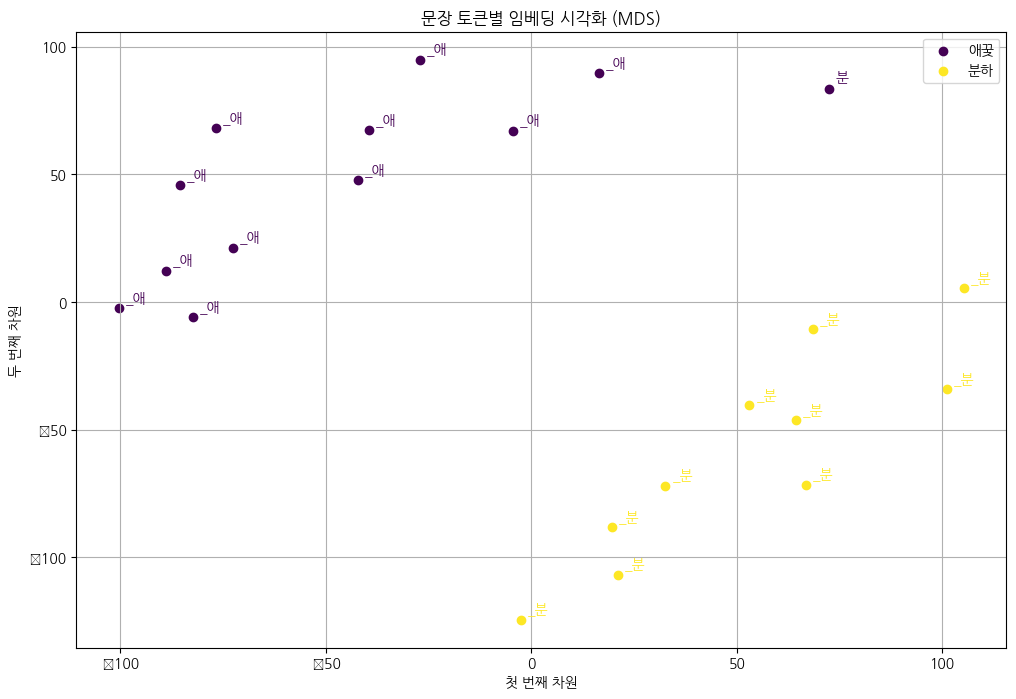

In [ ]:
import json
import pandas as pd

# 1. JSON 파일 읽기
file_path = "/content/drive/MyDrive/2025-2. 홍콩대 학술교류/corpus_after_del.json"
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# 2. "애꿎/VA"와 "분하/VA" 키에 해당하는 문장 리스트 추출
# (각 항목은 딕셔너리 형태로 {"sentence": 문장, ...}라고 가정)
애꿎_items = data.get("애꿎/VA", [])
분하_items = data.get("분하/VA", [])

# 각 리스트에서 "sentence" 값만 추출
애꿎_sentences = [item["sentence"] for item in 애꿎_items]
분하_sentences = [item["sentence"] for item in 분하_items]

# 3. DataFrame 생성: 열 이름은 "애꿎"과 "분하" (순서는 "애꿎"이 첫 번째)
df_pivot = pd.DataFrame({
    "애꿎": pd.Series(애꿎_sentences),
    "분하": pd.Series(분하_sentences)
})

# 4. 상위 10행만 선택
df_top10 = df_pivot.head(10)

# 5. 피벗된 DataFrame을 long format으로 변환
#    - 각 행은 하나의 문장과 해당 라벨("애꿎" 또는 "분하")을 가짐
df_long = pd.melt(df_top10, var_name="label", value_name="sentence")
df_long = df_long.dropna()  # NaN 값 제거

# 6. visualize_embeddings 함수에 넣을 리스트 생성
sentences = df_long["sentence"].tolist()
labels = df_long["label"].tolist()

# 7. visualize_embeddings 함수 호출 (tokenizer와 model은 미리 준비되어 있어야 함)
visualize_embeddings(sentences, labels, tokenizer, model)

문장 처리 중: 100%|██████████| 200/200 [00:46<00:00,  4.27it/s]



📌 변환된 토큰 결과를 스프레드시트에 저장 중...
✅ 토큰 변환 결과 저장 완료!

📌 MDS 차원 축소 중...

📌 시각화 준비 중...


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


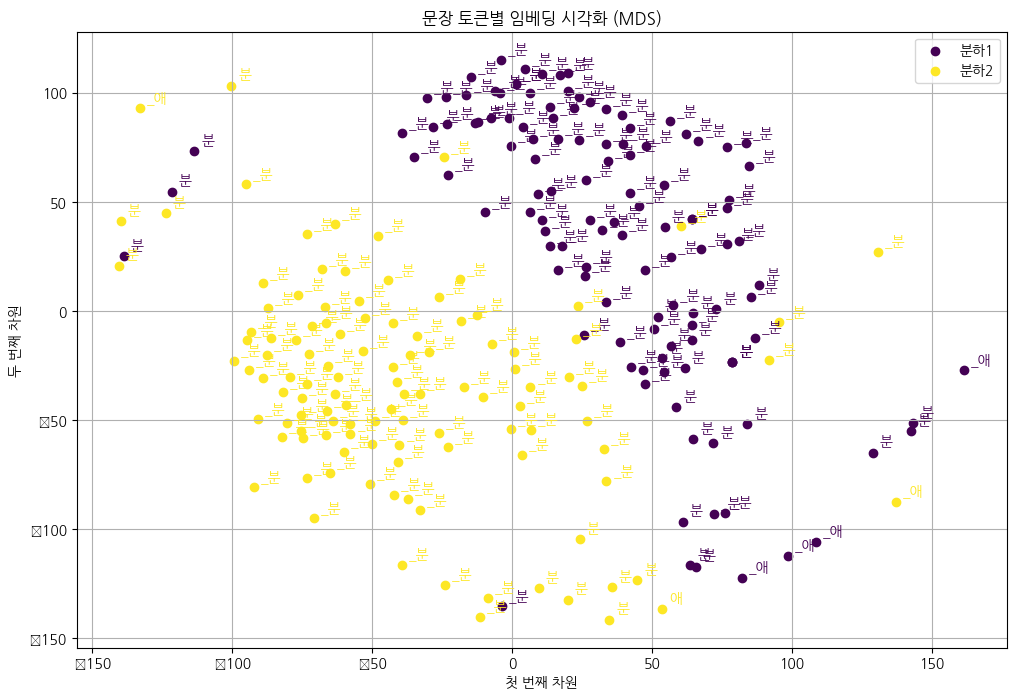

In [ ]:
# CSV 파일 로드
# file_path 이름을 바꾸면 됩니다.
file_path = "/content/drive/MyDrive/2025-2. 홍콩대 학술교류/output_bunha.csv"
df = pd.read_csv(file_path, encoding="utf-8")

# 'id' 열 제외
df = df.drop(columns=["id"], errors="ignore")

# Long Format 변환
df_long = df.melt(var_name="label", value_name="sentence").dropna()

# 각 라벨별 최대 10개 문장만 샘플링
df_sampled = df_long.groupby("label").head(100)

# 문장 및 라벨 리스트 생성
sentences = df_sampled["sentence"].tolist()
labels = df_sampled["label"].tolist()

# 4. visualize_embeddings 함수 호출
visualize_embeddings(sentences, labels, tokenizer, model)

일부 텍스트만 실행

In [ ]:
# 예제 문장
sentence = "나는 학교에 간다.눈이 내리고 있다."
inputs = tokenizer(sentence, return_tensors="pt")
token_ids = inputs['input_ids'][0].tolist()  # 토큰 ID 리스트

# 토큰 ID를 사람이 읽을 수 있는 문자로 변환
tokens = [clean_token(token_id) for token_id in token_ids]

print(tokens)  # 유니코드 깨짐 없이 출력

['[UNK:128000]', '나는', '_학교', '에', '_간', '다', '[UNK:13]', '[UNK:105940]', '[UNK:230]', '이', '_내', '리고', '_있다', '[UNK:13]']


In [ ]:
import torch
import numpy as np

# 확인할 한국어 단어 리스트
korean_words = ["되었습니다", "나는", " 학교", "에", " 간", "리고"]

# 토큰화
inputs = [tokenizer(word, return_tensors="pt") for word in korean_words]
inputs = [{k: v.to(model.device) for k, v in inp.items()} for inp in inputs]

# 모델 임베딩 계산
embeddings = []
for inp in inputs:
    with torch.no_grad():
        outputs = model(**inp)
    embeddings.append(outputs.last_hidden_state[0].cpu().numpy())  # (seq_length, hidden_dim)

# 결과 출력
for word, emb in zip(korean_words, embeddings):
    token_ids = inp["input_ids"].tolist()[0]
    print(f"Word: {word}")
    print(f"Token IDs: {token_ids}")
    print(f"Embedding shape: {emb.shape}")  # 각 단어의 임베딩 차원 출력
    print(f"Embedding values (first 5 dims): {emb[0, :100]}")  # 일부 값만 출력
    print("-" * 50)

Word: 되었습니다
Token IDs: [128000, 103889]
Embedding shape: (2, 4096)
Embedding values (first 5 dims): [ 1.26     2.633    0.7793   3.59     2.703    1.589   -1.146   -0.2285
 -2.213    1.238   -0.0096   0.2118   2.453   -3.482   -0.45    -0.56
  0.8125  -0.4336  -1.8955  -2.92    -2.994    0.4597  -2.516    3.799
  2.752   -0.5527   1.2      2.299   -1.934    2.86     0.6377   0.5396
  2.926   -3.564   -1.264   -0.878    0.3303  -0.994    0.973   -4.76
  3.793   -2.002    0.9946   1.26    -0.0664   3.846    2.23    -0.4272
  3.205   -0.4663  -3.021    1.944    1.591   -1.147   -2.443    1.502
 -0.604    0.0497  -0.05002 -1.175    2.52     0.788    0.316   -1.44
  2.205    1.643   -0.3206  -1.293   -0.2437   1.839    1.291    3.383
  0.4036  -1.377   -1.822    2.223    2.283   -1.271    0.3584   1.781
  3.234    1.929    0.705    1.22    -4.113    1.468   -1.108    2.25
 -2.44    -1.3125  -0.892   -4.01    -0.5767  -0.527   -1.398   -0.176
 -3.21    -1.979    0.3232  -1.92   ]
-----------

# 클러스터링